In [131]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from scipy.cluster import hierarchy
from sklearn.model_selection import cross_val_predict
import sklearn.model_selection as ms

import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters

import re

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [7]:
bloombergNeg = pd.read_csv("data/labels/bloomberg_labels/bloomberg_neg_train.csv")
bloombergPos = pd.read_csv("data/labels/bloomberg_labels/bloomberg_pos_train.csv")
bloombergNeu = pd.read_csv("data/labels/bloomberg_labels/bloomberg_neu_train.csv")
bloombergTrain = pd.concat([bloombergNeg, bloombergPos, bloombergNeu], ignore_index=True)
bloombergTrain = bloombergTrain[['text', 's_label']]

In [9]:
sandersNeg = pd.read_csv("data/labels/sanders_labels/sanders_neg_train.csv")
sandersPos = pd.read_csv("data/labels/sanders_labels/sanders_pos_train.csv")
sandersNeu = pd.read_csv("data/labels/sanders_labels/sanders_neu_train.csv")
sandersTrain = pd.concat([sandersNeg, sandersPos, sandersNeu], ignore_index=True)
sandersTrain = sandersTrain[['text', 's_label']]

In [14]:
buttigegNeg = pd.read_csv("data/labels/buttigieg_labels/buttigieg_neg_train.csv")
buttigegPos = pd.read_csv("data/labels/buttigieg_labels/buttigieg_pos_train.csv")
buttigegNeu = pd.read_csv("data/labels/buttigieg_labels/buttigieg_neu_train.csv")
buttigiegTrain = pd.concat([buttigegNeg, buttigegPos, buttigegNeu], ignore_index=True)
buttigiegTrain = buttigieg[['text', 's_label']]

In [85]:
buttigiegFull = pd.read_csv("data/tweets_full/buttigieg_full.csv")

In [86]:
buttigiegFull

,tweetid,date,text,favorites,retweets,location
0,1144416035375898627,2019-06-28,Pete Buttigieg is James Madison reincarnated,0.0,0.0,United States
1,810262559613919232,2016-12-17,"More Democrats like this, please: ""A letter fr...",0.0,0.0,United States
2,817842044785790981,2017-01-07,#Bernie fan 16 yrs before it was cool. \nProgr...,0.0,0.0,United States
3,822225176339382273,2017-01-19,@AbiWilks I like him but I'm pulling for longs...,0.0,0.0,United States
4,826811241775689728,2017-02-01,I have such a crush on Pete Buttigieg.,0.0,0.0,United States
...,...,...,...,...,...,...
6156,1235647846378098688,2020-03-05,@DavidCornDC @ewarren Well she wasn't the smar...,0.0,0.0,United States
6157,1235798531350257670,2020-03-06,1. Elizabeth Warren\n2. Julian Castro\n3. Bern...,0.0,0.0,United States
6158,1236495161548570624,2020-03-08,Pete Buttigieg_Thank-You to Supporters https:/...,0.0,0.0,United States
6159,1236520096136396803,2020-03-08,Pete Buttigieg Birthday Party in the Cedar Rap...,0.0,0.0,United States


In [19]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [23]:
bloombergTrain = clean_text(bloombergTrain, "text")
buttigiegTrain = clean_text(buttigiegTrain, "text")
sandersTrain = clean_text(sandersTrain, "text")

In [26]:
sandersTrain

,text,s_label
0,bernie sanders campaign accessed hillary clint...,-1
1,bernie sanders staffer playing dirty against h...,-1
2,bernie sanders will not get us free college im...,-1
3,what else did bernie sanders steal in today so...,-1
4,sorry this bernie sanders data breach has a fu...,-1
...,...,...
115,even on our worst days we are all better for t...,0
116,a rentcontrolled apartment in brooklyn is ever...,0
117,bernie sanders let me just say that i agree wi...,0
118,this is a mating call for a young bernie sanders,0


In [28]:
pipeline_sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', SGDClassifier()),
])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(sandersTrain['text'],
                                                    sandersTrain['s_label'],random_state = 0)

In [87]:
model = pipeline_sgd.fit(buttigiegTrain['text'], buttigiegTrain['s_label'])
y_predict = model.predict(buttigiegFull['text'])

In [92]:
freq = dict()
for i in y_predict:
    i = i.item()
    if i not in freq:
        freq[i] = 1
    else:
        freq[i] += 1

In [93]:
freq

{-1: 1292, 1: 2793, 0: 2076}

In [94]:
type(y_predict)

numpy.ndarray

In [95]:
buttigiegSentiment = pd.Series(y_predict)

In [96]:
buttigiegSentiment

0      -1
1       1
2       1
3       1
4       1
       ..
6156    1
6157    0
6158    0
6159    1
6160    0
Length: 6161, dtype: int64

In [97]:
buttigiegFull['sentiment'] = buttigiegSentiment

In [98]:
buttigiegFull

,tweetid,date,text,favorites,retweets,location,sentiment
0,1144416035375898627,2019-06-28,Pete Buttigieg is James Madison reincarnated,0.0,0.0,United States,-1
1,810262559613919232,2016-12-17,"More Democrats like this, please: ""A letter fr...",0.0,0.0,United States,1
2,817842044785790981,2017-01-07,#Bernie fan 16 yrs before it was cool. \nProgr...,0.0,0.0,United States,1
3,822225176339382273,2017-01-19,@AbiWilks I like him but I'm pulling for longs...,0.0,0.0,United States,1
4,826811241775689728,2017-02-01,I have such a crush on Pete Buttigieg.,0.0,0.0,United States,1
...,...,...,...,...,...,...,...
6156,1235647846378098688,2020-03-05,@DavidCornDC @ewarren Well she wasn't the smar...,0.0,0.0,United States,1
6157,1235798531350257670,2020-03-06,1. Elizabeth Warren\n2. Julian Castro\n3. Bern...,0.0,0.0,United States,0
6158,1236495161548570624,2020-03-08,Pete Buttigieg_Thank-You to Supporters https:/...,0.0,0.0,United States,0
6159,1236520096136396803,2020-03-08,Pete Buttigieg Birthday Party in the Cedar Rap...,0.0,0.0,United States,1


In [101]:
pd.to_datetime(buttigiegFull.date[0])

Timestamp('2019-06-28 00:00:00')

In [104]:
ts = list()
for index, row in buttigiegFull.iterrows():
    ts.append(pd.to_datetime(row['date']))

In [105]:
buttigiegFull['ts'] = pd.Series(ts)

In [106]:
buttigiegFull

,tweetid,date,text,favorites,retweets,location,sentiment,ts
0,1144416035375898627,2019-06-28,Pete Buttigieg is James Madison reincarnated,0.0,0.0,United States,-1,2019-06-28
1,810262559613919232,2016-12-17,"More Democrats like this, please: ""A letter fr...",0.0,0.0,United States,1,2016-12-17
2,817842044785790981,2017-01-07,#Bernie fan 16 yrs before it was cool. \nProgr...,0.0,0.0,United States,1,2017-01-07
3,822225176339382273,2017-01-19,@AbiWilks I like him but I'm pulling for longs...,0.0,0.0,United States,1,2017-01-19
4,826811241775689728,2017-02-01,I have such a crush on Pete Buttigieg.,0.0,0.0,United States,1,2017-02-01
...,...,...,...,...,...,...,...,...
6156,1235647846378098688,2020-03-05,@DavidCornDC @ewarren Well she wasn't the smar...,0.0,0.0,United States,1,2020-03-05
6157,1235798531350257670,2020-03-06,1. Elizabeth Warren\n2. Julian Castro\n3. Bern...,0.0,0.0,United States,0,2020-03-06
6158,1236495161548570624,2020-03-08,Pete Buttigieg_Thank-You to Supporters https:/...,0.0,0.0,United States,0,2020-03-08
6159,1236520096136396803,2020-03-08,Pete Buttigieg Birthday Party in the Cedar Rap...,0.0,0.0,United States,1,2020-03-08


In [110]:
buttigiegFull['test']= pd.to_datetime(buttigiegFull['ts']) - pd.to_timedelta(7, unit='d')

In [122]:
b = buttigiegFull.groupby([pd.Grouper(key='test', freq='W-MON')])['sentiment'].mean().reset_index().sort_values('test')

In [123]:
b

,test,sentiment
0,2016-05-02,1.000000
1,2016-05-09,NaN
2,2016-05-16,NaN
3,2016-05-23,NaN
4,2016-05-30,0.000000
...,...,...
196,2020-02-03,0.195462
197,2020-02-10,0.248201
198,2020-02-17,0.313131
199,2020-02-24,0.373673


In [124]:
b.to_csv("b.csv")

In [127]:
b = b.fillna(method="ffill")

In [128]:
b.to_csv("b.csv")

Text(0.5, 0, 'Date')

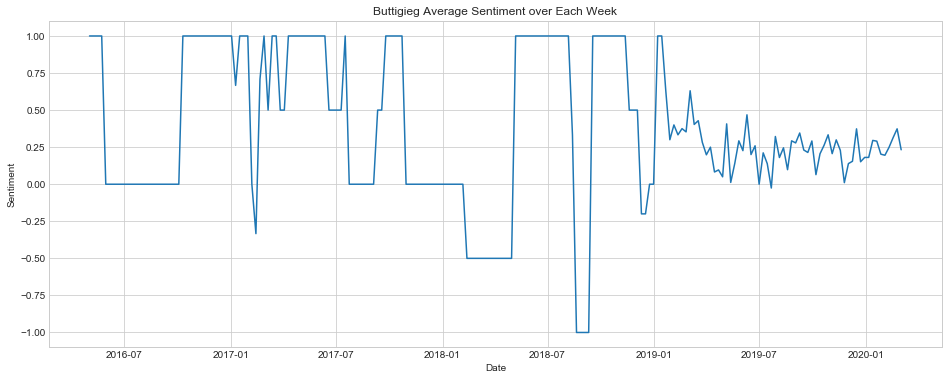

In [137]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=b["test"], y=b["sentiment"], data=b)
plt.title("Buttigieg Average Sentiment over Each Week")
ax.set_ylabel("Sentiment")
ax.set_xlabel("Date")